In [4]:
# Required imports
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from basistool import compute_integrals
from tqdm.notebook import tqdm

In [5]:
# ============================================================================
# RHF solver
# ============================================================================

# Integrals
margin = 2.0
dists = np.geomspace(0.7, 8.0, 40)
datas = []

print("Computing integrals for H2 at various distances...")
for dist in tqdm(dists):
    zgrid = np.arange(-dist / 2 - margin, dist / 2 + margin, 0.02)
    points = np.zeros((len(zgrid), 3))
    points[:, 2] = zgrid
    data = compute_integrals(
        ["H", "H"], [[0.0, 0.0, -dist / 2], [0.0, 0.0, dist / 2]], "aug-cc-pvdz.gbs", points
    )
    datas.append(data)

def solve_rhf():
    """Solve RHF for all distances and store results in datas"""
    for dist, data in zip(tqdm(dists, desc="RHF solver"), datas, strict=False):
        # Get a few operators. 
        coreham = data["kei"] + data["nai"]
        eri = data["eri"]
        olp = data["oi"]

        # The initial guess.
        eigvals, eigvecs = sp.linalg.eigh(coreham, olp)
        dm = np.dot(eigvecs[:, :1], eigvecs[:, :1].T)  # RHF

        # The scf cycle
        for _scf_counter in range(500):
            hartree = np.einsum("kmln,nm->kl", eri, dm)
            exchange = np.einsum("kmnl,nm->kl", eri, dm)
            fock = coreham + 2 * hartree - exchange  # Specific for RHF

            errors_rh = np.dot(fock, eigvecs) - np.einsum("ij,jk,k->ik", olp, eigvecs, eigvals)
            error_rh = np.linalg.norm(errors_rh)  # Frobenius norm
            if error_rh < 1e-7:
                break

            eigvals, eigvecs = sp.linalg.eigh(fock, olp)
            dm = np.dot(eigvecs[: , :1], eigvecs[: , :1].T)
        else:
            raise RuntimeError("SCF convergence failed")

        # Compute the _electronic_ energy.
        ham = coreham + hartree - 0.5 * exchange  # RHF
        electronic_energy = 2 * np.einsum("ij,ji", ham, dm)  # RHF

        # Compute the occupied orbital on the grid.
        psi0 = np.dot(eigvecs[:, 0], data["bfs"])  # RHF

        # Store results back into the data dictionary.
        data["eigvals_rhf"] = eigvals
        data["eigvecs_rhf"] = eigvecs
        data["energy_rhf"] = electronic_energy + 1 / dist
        data["electronic_energy_rhf"] = electronic_energy
        data["nuclear_repulsion"] = 1 / dist
        data["density_rhf"] = 2 * psi0**2  # RHF
        data["fock_rhf"] = fock
        data["dm_rhf"] = dm

solve_rhf()

print("\nRHF solved for all distances!")

Computing integrals for H2 at various distances...


  0%|          | 0/40 [00:00<?, ?it/s]

RHF solver:   0%|          | 0/40 [00:00<?, ?it/s]


RHF solved for all distances!



Plotting results...


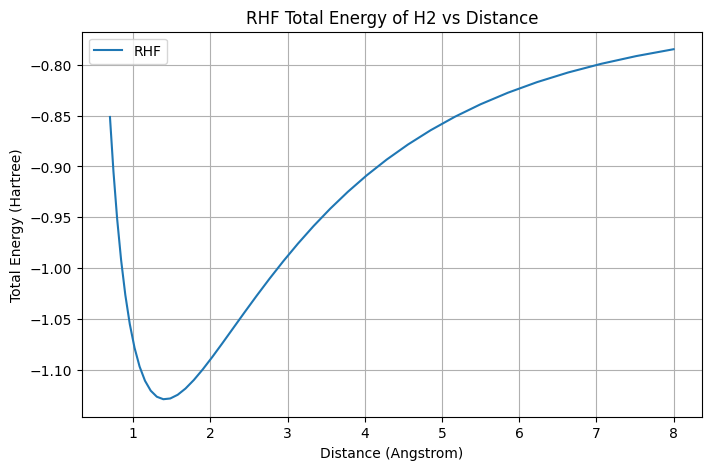

In [6]:
print("\nPlotting results...")
# Extract energies
energies_rhf = [data["energy_rhf"] for data in datas]
# Plot energies
plt.figure(figsize=(8, 5))
plt.plot(dists, energies_rhf, label="RHF", color="C0")
plt.xlabel("Distance (Angstrom)")
plt.ylabel("Total Energy (Hartree)")
plt.title("RHF Total Energy of H2 vs Distance")
plt.legend()
plt.grid()

In [7]:




# ============================================================================
# Now compute CI with singles + doubles for each distance
# ============================================================================

def compute_ci_energy(data, dist):
    """
    Compute CI energy (reference + singles + doubles) for a single geometry
    
    Parameters:
    -----------
    data :  dict
        Contains integrals and RHF results
    dist : float
        Internuclear distance
        
    Returns:
    --------
    dict with CI results
    """
    # Extract data
    h1e = data["kei"] + data["nai"]  # One-electron Hamiltonian
    eri = data["eri"]  # Two-electron integrals (already in MO-like basis)
    eigvecs = data["eigvecs_rhf"]  # MO coefficients from RHF
    eigvals = data["eigvals_rhf"]  # Orbital energies
    E_HF = data["energy_rhf"]  # Total HF energy (electronic + nuclear)
    E_elec_HF = data["electronic_energy_rhf"]  # Electronic part only
    nuc_rep = data["nuclear_repulsion"]
    
    # Number of basis functions
    nbf = h1e.shape[0]
    nocc = 1  # H2 has 1 doubly occupied orbital
    nvir = nbf - nocc
    
    # Transform integrals to MO basis
    # h1e_mo = C^T h1e C
    h1e_mo = eigvecs.T @ h1e @ eigvecs
    
    # eri_mo:  transform 4-index ERI to MO basis
    # This is (pq|rs) = C_pi C_qj C_rk C_sl (ij|kl)
    eri_mo = np.einsum('pi,qj,rk,sl,ijkl->pqrs', eigvecs, eigvecs, eigvecs, eigvecs, eri)
    
    # Build Fock matrix in MO basis
    fock_mo = h1e_mo. copy()
    for p in range(nbf):
        for q in range(nbf):
            for j in range(nocc):
                fock_mo[p, q] += 2.0 * eri_mo[p, q, j, j] - eri_mo[p, j, j, q]
    
    # ========================================================================
    # Build configuration list
    # ========================================================================
    configurations = []
    
    # Reference
    configurations.append(('ref', None))
    
    # Singles:  i=0 → a (a = 1.. nbf-1)
    for a in range(nocc, nbf):
        configurations.append(('S', (0, a)))
    
    # Doubles: both from i=0 → (a,b) with a<b
    for a in range(nocc, nbf):
        for b in range(a+1, nbf):
            configurations.append(('D', (0, 0, a, b)))
    
    n_config = len(configurations)
    
    # ========================================================================
    # Compute Hamiltonian matrix elements
    # ========================================================================
    def get_matrix_element(config_i, config_j):
        """Compute <Ψ_i|H|Ψ_j> using Slater-Condon rules"""
        type_i, data_i = config_i
        type_j, data_j = config_j
        
        # Ref - Ref
        if type_i == 'ref' and type_j == 'ref':
            return E_HF
        
        # Ref - Single
        if type_i == 'ref' and type_j == 'S': 
            i, a = data_j
            return fock_mo[i, a]  # Brillouin theorem → should be ~0
        
        if type_i == 'S' and type_j == 'ref':
            return get_matrix_element(config_j, config_i)
        
        # Ref - Double
        if type_i == 'ref' and type_j == 'D':
            i1, i2, a1, a2 = data_j
            # <Ψ0|H|Ψ_ii^ab> = <ij||ab> = (ia|jb) - (ib|ja)
            return eri_mo[i1, a1, i2, a2] - eri_mo[i1, a2, i2, a1]
        
        if type_i == 'D' and type_j == 'ref':
            return get_matrix_element(config_j, config_i)
        
        # Single - Single
        if type_i == 'S' and type_j == 'S':
            i_i, a_i = data_i
            i_j, a_j = data_j
            
            if i_i == i_j and a_i == a_j: 
                # Diagonal
                return E_HF + (eigvals[a_i] - eigvals[i_i])
            else:
                # Off-diagonal (typically small or zero)
                return 0.0
        
        # Single - Double
        if type_i == 'S' and type_j == 'D': 
            i_s, a_s = data_i
            i1, i2, a1, a2 = data_j
            
            # <Ψ_i^a|H|Ψ_jj^bc> for i=j=0
            if i_s == i1 == i2:
                # Coupling term
                val = eri_mo[a_s, a1, i1, a2] - eri_mo[a_s, a2, i1, a1]
                val += eri_mo[a_s, a2, i2, a1] - eri_mo[a_s, a1, i2, a2]
                return val
            return 0.0
        
        if type_i == 'D' and type_j == 'S':
            return get_matrix_element(config_j, config_i)
        
        # Double - Double
        if type_i == 'D' and type_j == 'D':
            i1_i, i2_i, a1_i, a2_i = data_i
            i1_j, i2_j, a1_j, a2_j = data_j
            
            if (i1_i, i2_i, a1_i, a2_i) == (i1_j, i2_j, a1_j, a2_j):
                # Diagonal
                delta_E = (eigvals[a1_i] - eigvals[i1_i]) + (eigvals[a2_i] - eigvals[i2_i])
                return E_HF + delta_E
            else:
                # Off-diagonal coupling between different doubles
                # Simplified: only if they share some orbitals
                # Full implementation would check orbital overlap and apply rules
                return 0.0
        
        return 0.0
    
    # Build Hamiltonian matrix
    H_CI = np.zeros((n_config, n_config))
    for i in range(n_config):
        for j in range(i, n_config):
            H_CI[i, j] = get_matrix_element(configurations[i], configurations[j])
            H_CI[j, i] = H_CI[i, j]
    
    # Diagonalize
    eigenvalues_CI, eigenvectors_CI = np.linalg.eigh(H_CI)
    
    E_CI = eigenvalues_CI[0]
    c_ref = eigenvectors_CI[0, 0]
    
    return {
        'E_HF': E_HF,
        'E_CI': E_CI,
        'E_corr': E_CI - E_HF,
        'c_ref_squared': c_ref**2,
        'n_config': n_config,
        'eigenvalues':  eigenvalues_CI,
        'eigenvectors': eigenvectors_CI,
        'configurations':  configurations
    }



In [ ]:
# ============================================================================
# Compute CI for all distances (OPTIMIZED)
# ============================================================================
print("\nComputing CI energies...")

# Pre-allocate lists for better memory performance
n_distances = len(dists)
ci_results = [None] * n_distances

# Option 1: Parallel processing (if compute_ci_energy is CPU-bound)
from multiprocessing import Pool
from functools import partial

def compute_ci_with_dist(dist_data_tuple):
    """Helper function for parallel processing"""
    dist, data = dist_data_tuple
    result = compute_ci_energy(data, dist)
    result['dist'] = dist
    return result, data

# Use all available CPU cores (adjust n_processes as needed)
with Pool() as pool:
    results = list(tqdm(
        pool.imap(compute_ci_with_dist, zip(dists, datas)),
        total=n_distances,
        desc="CI calculation"
    ))

# Unpack results
for i, (result, data) in enumerate(results):
    ci_results[i] = result
    data['ci_result'] = result

print("\nCI calculations complete!")

# ============================================================================
# Summary and comparison (OPTIMIZED)
# ============================================================================
print("\n" + "=" * 70)
print("Summary:  HF vs CI energies as function of internuclear distance")
print("=" * 70)
print(f"{'R (Å)':<10} {'E_HF (Ha)':<15} {'E_CI (Ha)':<15} {'E_corr (Ha)':<15} {'|c0|²':<10}")
print("=" * 70)

# Use slicing instead of loop for every 5th point
for res in ci_results[:: 5]: 
    print(f"{res['dist']:<10.3f} {res['E_HF']: <15.8f} {res['E_CI']:<15.8f} "
          f"{res['E_corr']:<15.8f} {res['c_ref_squared']:<10.6f}")

print("=" * 70)

# ============================================================================
# Plot results (OPTIMIZED)
# ============================================================================
import matplotlib.pyplot as plt
import numpy as np

# Extract data once using list comprehensions (faster than repeated loops)
distances = np.array([r['dist'] for r in ci_results])
E_HF = np.array([r['E_HF'] for r in ci_results])
E_CI = np.array([r['E_CI'] for r in ci_results])
E_corr = np.array([r['E_corr'] for r in ci_results])
c_ref_squared = np.array([r['c_ref_squared'] for r in ci_results])

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Energy curves
ax = axes[0, 0]
ax.plot(distances, E_HF, 'o-', label='HF', linewidth=2)
ax.plot(distances, E_CI, 's-', label='CI (S+D)', linewidth=2)
ax.set_xlabel('Internuclear distance (Å)', fontsize=12)
ax.set_ylabel('Total energy (Hartree)', fontsize=12)
ax.set_title('H₂ Energy:  HF vs CI', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Correlation energy
ax = axes[0, 1]
ax.plot(distances, E_corr, 'o-', color='red', linewidth=2)
ax.set_xlabel('Internuclear distance (Å)', fontsize=12)
ax.set_ylabel('Correlation energy (Hartree)', fontsize=12)
ax.set_title('Correlation Energy vs Distance', fontsize=14)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)

# HF reference weight
ax = axes[1, 0]
ax.plot(distances, c_ref_squared, 'o-', color='green', linewidth=2)
ax.set_xlabel('Internuclear distance (Å)', fontsize=12)
ax.set_ylabel('|c₀|² (HF weight)', fontsize=12)
ax.set_title('HF Determinant Weight in CI', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.05])

# Energy difference (zoomed)
ax = axes[1, 1]
ax.plot(distances, 1000 * E_corr, 'o-', color='purple', linewidth=2)
ax.set_xlabel('Internuclear distance (Å)', fontsize=12)
ax.set_ylabel('Correlation energy (mHartree)', fontsize=12)
ax.set_title('Correlation Energy (milliHartree)', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('h2_hf_vs_ci. png', dpi=300, bbox_inches='tight')
print("\nPlot saved as 'h2_hf_vs_ci.png'")
plt.show()

# ============================================================================
# Find equilibrium distances (OPTIMIZED)
# ============================================================================
print("\n" + "=" * 70)
print("Equilibrium geometries")
print("=" * 70)

# Use numpy for faster argmin
idx_hf = np.argmin(E_HF)
idx_ci = np.argmin(E_CI)

print(f"HF:   R_eq = {ci_results[idx_hf]['dist']:.3f} Å, "
      f"E = {ci_results[idx_hf]['E_HF']:.8f} Ha")
print(f"CI:   R_eq = {ci_results[idx_ci]['dist']:.3f} Å, "
      f"E = {ci_results[idx_ci]['E_CI']:.8f} Ha")
print("=" * 70)


Computing CI energies...


CI calculation:   0%|          | 0/40 [00:00<?, ?it/s]

Process SpawnPoolWorker-2:
Traceback (most recent call last):
Process SpawnPoolWorker-5:
Traceback (most recent call last):
Process SpawnPoolWorker-1:
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py", line 387, in get
    return _ForkingPickler.loads(res)
           ~~~~~~~~~~~~~~~~~~~~~^^^^^
AttributeError: Can't get attribute 'compute_ci_with_dist' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>
Traceback (most rece